In [ ]:
from tensorflow.keras.layers import Input, add, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import Embedding, multiply, BatchNormalization, Concatenate, Input
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 我們會使用到一些內建的資料庫, MAC需要加入以下兩行, 才不會把對方的ssl憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
from zipfile import ZipFile
zfile = ZipFile("horse2zebra.zip")
zfile.extractall()

In [ ]:
# 要記得解壓縮資料集
# 下載網址: https://drive.google.com/open?id=1d4lc0kZ85PokmzzLXGbcqQM60HJrlV96
# 下載網址2: https://reurl.cc/nKrd8
dataset_path = "horse2zebra"

訓練資料(馬)維度: (256, 256, 3)


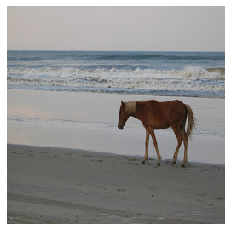

In [ ]:
from PIL import Image
import os
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img


a_train = []
a_path = os.path.join(dataset_path, "trainA")
# A: 走過所有馬的照片
for fname in os.listdir(a_path):
    img_path = os.path.join(a_path, fname)
    if not fname.startswith("."):
        a_train.append(img_path)
# 隨機選一個印出來
i = random.randint(0, len(a_train) - 1)
a_img = np.array(load_img(a_train[i]))
plt.axis("off")
plt.imshow(a_img)
print("訓練資料(馬)維度:", a_img.shape)

訓練資料(斑馬)維度: (256, 256, 3)


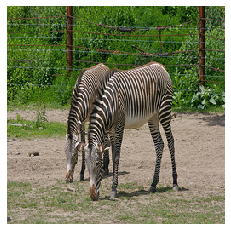

In [ ]:
b_train = []
b_path = os.path.join(dataset_path, "trainB")
# B: 走過所有斑馬的照片
for fname in os.listdir(b_path):
    img_path = os.path.join(b_path, fname)
    if not fname.startswith("."):
        b_train.append(img_path)

i = random.randint(0, len(b_train) - 1)
b_img = np.array(load_img(b_train[i]))
plt.axis("off")
plt.imshow(b_img)
print("訓練資料(斑馬)維度:", b_img.shape)

In [ ]:
# Discriminator: 跟我們的pix2pix是完全一樣的樣式, 不過為了可以建立兩個, 定義函式
def build_discriminator():

    def d_layer(layer_input, filters, f_size=4):
        # Conv2D -> LeakyReLu -> Instance Normalization
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = InstanceNormalization(axis=-1, center=False, scale=False)(d)
        d = LeakyReLU(alpha=0.2)(d)
        return d

    img = Input(shape=(256, 256, 3))

    d1 = d_layer(img, 32)
    d2 = d_layer(d1, 64)
    d3 = d_layer(d2, 128)
    d4 = d_layer(d3, 256)
    # revised
    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, validity)

In [ ]:
def build_generator():
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = InstanceNormalization(axis=-1, center=False, scale=False)(d)
            d = Activation("relu")(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same')(u)
            u = InstanceNormalization(axis=-1, center=False, scale=False)(u)
            u = Activation("relu")(u)
            u = Concatenate()([u, skip_input])
            return u



        # Image input
        d0 = Input(shape=(256, 256, 3))

        # Downsampling
        d1 = conv2d(d0, 32)
        d2 = conv2d(d1, 64)
        d3 = conv2d(d2, 128)
        d4 = conv2d(d3, 256)
        d5 = conv2d(d4, 512)
        d6 = conv2d(d5, 512)
        d7 = conv2d(d6, 512)
        d8 = conv2d(d7, 512)

        # Upsampling
        u0 = deconv2d(d8, d7, 512)
        u1 = deconv2d(u0, d6, 512)
        u2 = deconv2d(u1, d5, 512)
        u3 = deconv2d(u2, d4, 256)
        u4 = deconv2d(u3, d3, 128)
        u5 = deconv2d(u4, d2, 64)
        u6 = deconv2d(u5, d1, 32)


        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)


In [ ]:
from tensorflow.keras.optimizers import Adam
d_A = build_discriminator()
d_A.compile(loss='mse', optimizer=Adam(0.0002, 0.5))
d_A.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      1568      
_________________________________________________________________
instance_normalization (Inst (None, 128, 128, 32)      0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 64)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0     

In [ ]:
d_B = build_discriminator()
d_B.compile(loss='mse', optimizer=Adam(0.0002, 0.5))
d_B.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      1568      
_________________________________________________________________
instance_normalization_4 (In (None, 128, 128, 32)      0         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
instance_normalization_5 (In (None, 64, 64, 64)        0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)        0   

In [ ]:
# 建立Generator, 不過不用編譯, 因為我們沒有要訓練他
g_AB = build_generator()
g_BA = build_generator()
g_AB.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 32) 1568        input_3[0][0]                    
__________________________________________________________________________________________________
instance_normalization_8 (Insta (None, 128, 128, 32) 0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           instance_normalization_8[0][0]   
____________________________________________________________________________________________

In [ ]:


# 輸入圖片的大小
img_A = Input(shape=(256, 256, 3))
img_B = Input(shape=(256, 256, 3))

# 創造偽作
fake_B = g_AB(img_A)
fake_A = g_BA(img_B)
# 偽作再偽造回原作
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)
# 這裡比較特別, 我們希望A類的圖片就算丟進A->B轉換還是維持
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

# 記得在合併模型的時候我們要固定住Discriminator
d_A.trainable = False
d_B.trainable = False

# 對兩個偽作接上Discriminator
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

# 這裡我們由於有多個ouput, 所以也要接多個loss
# mse會對預測很差的做很大的懲罰
# 對於畫, 我們沒有要給很大的懲罰, 所以我們選擇mae
combined = Model(inputs=[img_A, img_B],
                 outputs=[ valid_A, valid_B,
                           reconstr_A, reconstr_B,
                           img_A_id, img_B_id])
combined.compile(loss=['mse', 'mse',
                       'mae', 'mae',
                       'mae', 'mae'],
                 loss_weights=[  1, 1,
                                10, 10,
                                 5, 5],
                 optimizer=Adam(0.0002, 0.5))
combined.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 256, 256, 3)  41919427    input_6[0][0]                    
                                                                 model_2[1][0]                    
                                                                 input_5[0][0]                    
____________________________________________________________________________________________

In [ ]:
patch = int(256 / 2**4)
disc_patch = (patch, patch, 1)
disc_patch

(16, 16, 1)

In [ ]:
batch_size = 1
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

In [ ]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from PIL import Image

train_count = 80000
for train in range(0, train_count):

    ida = np.random.randint(0, len(a_train), batch_size)
    idb = np.random.randint(0, len(b_train), batch_size)


    imgs_A = []
    imgs_B = []
    for i in ida:
        imgs_A.append((np.array(load_img(a_train[i])) - 127.5)/127.5)
    for i in idb:
        imgs_B.append((np.array(load_img(b_train[i])) - 127.5)/127.5)
    imgs_A = np.array(imgs_A)
    imgs_B = np.array(imgs_B)

    fake_B = g_AB.predict(imgs_A)
    fake_A = g_BA.predict(imgs_B)


    d_A.trainable = True
    d_B.trainable = True
    dA_loss_real = d_A.train_on_batch(imgs_A, valid)
    dA_loss_fake = d_A.train_on_batch(fake_A, fake)
    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

    dB_loss_real = d_B.train_on_batch(imgs_B, valid)
    dB_loss_fake = d_B.train_on_batch(fake_B, fake)
    dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

    # Total disciminator loss
    d_loss = 0.5 * np.add(dA_loss, dB_loss)


    d_A.trainable = False
    d_B.trainable = False
    g_loss = combined.train_on_batch([imgs_A, imgs_B],
                                     [valid, valid,
                                      imgs_A, imgs_B,
                                      imgs_A, imgs_B])

    if (train + 1) % 1000 == 0:
        dash = "-" * 15
        print(dash, "Train", train + 1, dash)
        print("Discriminator loss:", d_loss)
        print("DA, DB loss:", [dA_loss, dB_loss])
        print("Generator loss:", g_loss)



--------------- Train 1000 ---------------
Discriminator loss: 0.22747376933693886
DA, DB loss: [0.0767040029168129, 0.3782435357570648]
Generator loss: [2.852612257003784, 0.8324819207191467, 0.29084882140159607, 0.05248253419995308, 0.08647378534078598, 0.02687225118279457, 0.04107142612338066]
--------------- Train 2000 ---------------
Discriminator loss: 0.27852000668644905
DA, DB loss: [0.1511221006512642, 0.4059179127216339]
Generator loss: [2.827253580093384, 0.4705389738082886, 0.41205132007598877, 0.05838439613580704, 0.09434056282043457, 0.02774317003786564, 0.05573958531022072]
--------------- Train 3000 ---------------
Discriminator loss: 0.2009399477392435
DA, DB loss: [0.11648629978299141, 0.2853935956954956]
Generator loss: [3.03395414352417, 0.6429893970489502, 0.3484736680984497, 0.06186206638813019, 0.09744913876056671, 0.04024731367826462, 0.04962850362062454]
--------------- Train 4000 ---------------
Discriminator loss: 0.24249863624572754
DA, DB loss: [0.280448488

--------------- Train 29000 ---------------
Discriminator loss: 0.14980698563158512
DA, DB loss: [0.09897428378462791, 0.20063968747854233]
Generator loss: [2.936433792114258, 0.6154534220695496, 0.410215824842453, 0.06719672679901123, 0.08038429915904999, 0.043503038585186005, 0.043487854301929474]
--------------- Train 30000 ---------------
Discriminator loss: 0.23587385192513466
DA, DB loss: [0.18605203181505203, 0.2856956720352173]
Generator loss: [3.5593550205230713, 0.5695510506629944, 0.4229341745376587, 0.09104053676128387, 0.10553306341171265, 0.06292583048343658, 0.05730094760656357]
--------------- Train 31000 ---------------
Discriminator loss: 0.1738726571202278
DA, DB loss: [0.16699442267417908, 0.18075089156627655]
Generator loss: [2.8735809326171875, 0.5238999128341675, 0.47991159558296204, 0.06253800541162491, 0.08525624126195908, 0.03671230003237724, 0.0416531041264534]
--------------- Train 32000 ---------------
Discriminator loss: 0.13986258581280708
DA, DB loss: [0

--------------- Train 57000 ---------------
Discriminator loss: 0.19625093881040812
DA, DB loss: [0.27843569964170456, 0.11406617797911167]
Generator loss: [3.110219955444336, 0.5864602327346802, 0.46439480781555176, 0.09088575094938278, 0.06633961200714111, 0.06132641062140465, 0.03609586879611015]
--------------- Train 58000 ---------------
Discriminator loss: 0.12327481061220169
DA, DB loss: [0.10578657686710358, 0.1407630443572998]
Generator loss: [3.353377342224121, 0.7223314642906189, 0.5878878831863403, 0.0790272206068039, 0.07980687916278839, 0.04658772796392441, 0.04437568783760071]
--------------- Train 59000 ---------------
Discriminator loss: 0.18592733144760132
DA, DB loss: [0.1720750853419304, 0.19977957755327225]
Generator loss: [3.029578685760498, 0.6399192214012146, 0.36973559856414795, 0.060056421905756, 0.09746581315994263, 0.04129142314195633, 0.047648899257183075]
--------------- Train 60000 ---------------
Discriminator loss: 0.22570033743977547
DA, DB loss: [0.22

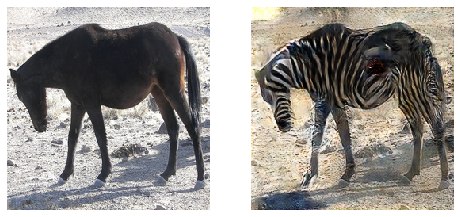

In [ ]:
plt.figure(figsize=(8, 4))
idx = random.randint(0, len(a_train) - 1)
drawing = np.array(load_img(a_train[idx]))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(drawing)

drawing_shaped = (drawing - 127.5)/127.5
fake_scenery = g_AB.predict(np.array([drawing_shaped]))
fake_scenery = 0.5 * fake_scenery + 0.5
plt.axis("off")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(fake_scenery[0])

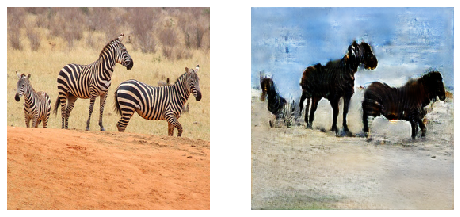

In [ ]:
plt.figure(figsize=(8, 4))
idx = random.randint(0, len(b_train) - 1)
scenery = np.array(load_img(b_train[idx]))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(scenery)

scenery_shaped = (scenery - 127.5)/127.5
fake_drawing = g_BA.predict(np.array([scenery_shaped]))
fake_drawing = 0.5 * fake_drawing + 0.5
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(fake_drawing[0])